In [1]:
from comet_ml import Experiment
import json

In [2]:
import os
os.listdir("/glock/gun/notebooks/")

['skladanka',
 'unity2coco.ipynb',
 'create_coco_glock_dataset.ipynb',
 'Dockerfile',
 'coco_from_edge.ipynb',
 'coco_from_aws.ipynb',
 'api_key.txt',
 'a.txt',
 'detectron_glock.ipynb',
 '.ipynb_checkpoints',
 'Untitled.ipynb',
 'edgeai.ipynb']

In [3]:
with open("/glock/gun/notebooks/api_key.txt", "r") as f:
    api_key = json.load(f)
    print("opened")

opened


In [4]:
'''
hyper_params = {
    "learning_rate": 0.001,
    "IMS_PER_BATCH": 4,
    "GAMMA" : 0.8,
    "FREEZE_AT" : 1,
    'IMS_PER_BATCH' : 4,
    "WARMUP_ITERS" : 10000,
    'SOLVER_STEPS':(40000, 80000, 120000, 200000, 500000)
}

experiment = Experiment(project_name="gun", api_key=api_key['api_key'])
experiment.log_parameters(hyper_params)
'''

'\nhyper_params = {\n    "learning_rate": 0.001,\n    "IMS_PER_BATCH": 4,\n    "GAMMA" : 0.8,\n    "FREEZE_AT" : 1,\n    \'IMS_PER_BATCH\' : 4,\n    "WARMUP_ITERS" : 10000,\n    \'SOLVER_STEPS\':(40000, 80000, 120000, 200000, 500000)\n}\n\nexperiment = Experiment(project_name="gun", api_key=api_key[\'api_key\'])\nexperiment.log_parameters(hyper_params)\n'

In [5]:
from detectron2.data.datasets import register_coco_instances
#register_coco_instances("weapons", {}, "/Pobrane/trainval.json", "/Pobrane/images")
register_coco_instances("weapons_test", {}, "/Pobrane/test.json", "/Pobrane/images")
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [6]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [7]:
dataset_dicts_test = DatasetCatalog.get("weapons_test")
#glock_metadata = MetadataCatalog.get("weapons")
glock_metadata_test = MetadataCatalog.get("weapons_test")

In [8]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/images/57.png
/Pobrane/images/71.png
/Pobrane/images/38.png
/Pobrane/images/23.png
/Pobrane/images/36.png
/Pobrane/images/78.png
/Pobrane/images/62.png
/Pobrane/images/8.png
/Pobrane/images/35.png
/Pobrane/images/24.png


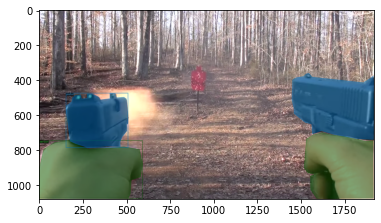

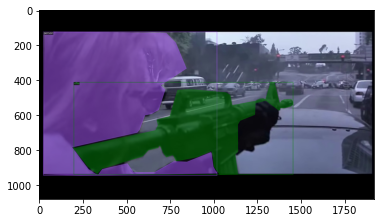

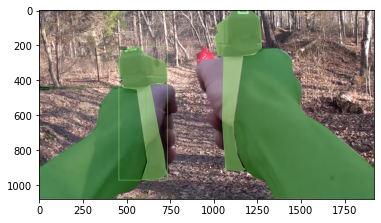

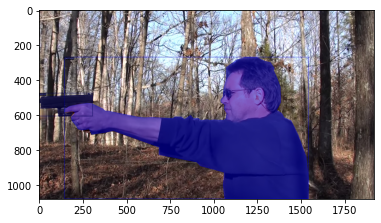

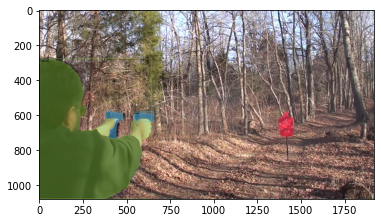

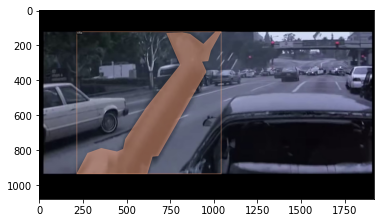

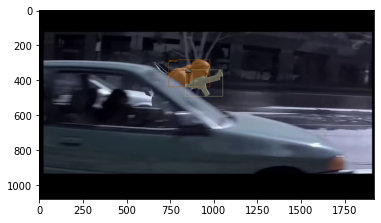

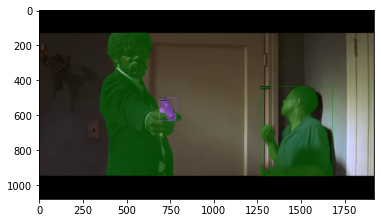

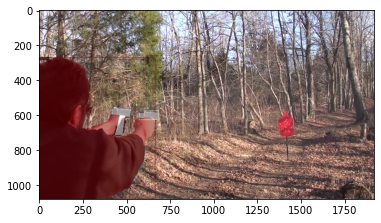

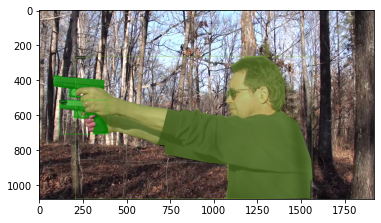

In [9]:
for d in random.sample(dataset_dicts_test, 10):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata_test, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [10]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [11]:
from datetime import datetime
import os

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons"#_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 2
cfg.MODEL.BACKBONE.FREEZE_AT=hyper_params['FREEZE_AT']
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = hyper_params['IMS_PER_BATCH'] # 32
cfg.SOLVER.BASE_LR = hyper_params['learning_rate'] # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 500_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  hyper_params['WARMUP_ITERS']
cfg.SOLVER.GAMMA = hyper_params['GAMMA']
cfg.SOLVER.STEPS = hyper_params['SOLVER_STEPS']

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 100000_000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

NameError: name 'hyper_params' is not defined

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open("/glock/gun/config.yml", "w") as f:
    f.write(cfg.dump())

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


In [ ]:
class MyTrainer(DefaultTrainer):
    
view raw

In [ ]:
https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [ ]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("weapons")
glock_test_metadata = MetadataCatalog.get("weapons")

In [ ]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())